# Link Prediction

In [3]:
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx, negative_sampling
from torch_geometric.data import Data
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv, to_hetero_with_bases, GATConv
from sklearn.metrics import confusion_matrix
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE, GAE
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

## 1. data analysis

In [4]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")

In [3]:
print("number of nodes: ", len(g.nodes))
print("number of edges: ",len(g.edges))

number of nodes:  3363
number of edges:  13547


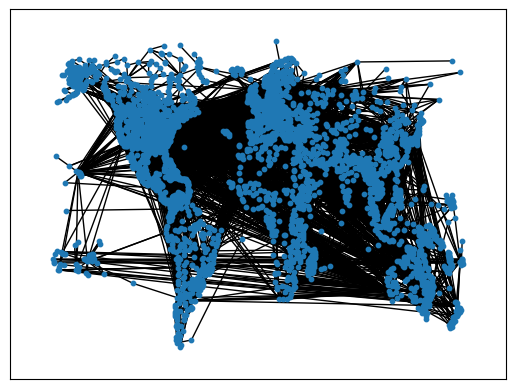

In [4]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)

With Gephi we have optain this graph:
![](./gephi_analyse/airports_coord_pop_graph.svg)

In [8]:
g.nodes()['0']

{'lon': -145.50972222222222,
 'lat': -17.35388888888889,
 'population': 10000,
 'country': 'FRENCH_POLYNESIA',
 'city_name': 'Anaa'}

In [5]:
g.graph = {}
data = from_networkx(g, group_node_attrs=["lon", "lat"])
edge_index = data.edge_index
data: Data = train_test_split_edges(data)   
data.edge_index = edge_index
data

c:\Users\arthu\miniconda3\envs\pytorchgeo\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 2], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354], edge_index=[2, 27094])

après une  première analyse on se rend compte que grouper avec l'attribut population nous donne des "mauvais" résultat (auc: 0.5, accuracy: 0.5) ces valeurs

- x=[3363, 2] => pour chaque noeud, les coordonnées lat et lon
- val_pos_edge_index=[2, 677] => 2 ligne, la première c'est d'où on pars, la deuxième c'est où on va
- test_pos_edge_index=[2, 1354] => /
- train_pos_edge_index=[2, 23032] => /
- train_neg_adj_mask=[3363, 3363] => matrice d'adjacence, vrai si pas de lien, faux sinon
- val_neg_edge_index=[2, 677] => /
- test_neg_edge_index=[2, 1354]) => /


## 2. First Model GAE

### VGAE with Basic Encoder

In [11]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv_mu = GCNConv(2*out_channels, out_channels)
        self.conv_logstd = GCNConv(2*out_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [12]:
def train(model, eta: float, train_data):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=eta)
    optim.zero_grad()
    z = model.encode(train_data.x, train_data.train_pos_edge_index)
    loss = model.recon_loss(z, train_data.train_pos_edge_index) + (1 / train_data.x.size(0)) * model.kl_loss() 
    loss.backward()
    optim.step()
    return float(loss)

In [13]:
def calc_accu_val(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_pred = model.decode(z, data.val_pos_edge_index)
    neg_pred = model.decode(z, data.val_neg_edge_index)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0)

    pred_binary = (preds > 0.9).float()

    accuracy = accuracy_score(labels.cpu(), pred_binary.cpu())

    return accuracy

def calc_accu_test(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_score = model.decode(z, data.test_pos_edge_index)
    neg_score = model.decode(z, data.test_neg_edge_index)

    y_true = torch.cat([torch.ones(data.test_pos_edge_index.size(1)), 
                         torch.zeros(data.test_neg_edge_index.size(1))])

    scores = torch.cat([pos_score, neg_score])

    y_pred = (scores > 0.9).float()

    accuracy = accuracy_score(y_true.cpu(), y_pred.cpu())

    return accuracy

In [15]:
def hyperparameter_tuning(data, num_epochs_values, lr_values, outputs_values):
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for output in outputs_values:
                print(f'Trial {i} : Epoch {num_epoch}, LR: {lr}, NB output: {output} \n')
                for epoch in range(num_epoch):
                    model = Encoder(data.num_features, output)
                    model = VGAE(model)
                    loss = train(model, lr, data) 
                    if (loss < min_loss):
                        min_loss = loss
                        bepoch = epoch
                        blr = lr
                        bout = output
                        bmodel = model
                        print(f'Epoch {bepoch}, LR: {blr}, NB output: {bout}, Loss: {min_loss:.4f}')
                i += 1
    return bmodel, min_loss, bepoch, blr, bout

bmodel, min_loss, bepoch, blr, bout = hyperparameter_tuning(data, [100], [0.01, 0.001], [64])

Trial 0 : Epoch 100, LR: 0.01, NB output: 64 

Epoch 0, LR: 0.01, NB output: 64, Loss: 348722.1562
Epoch 2, LR: 0.01, NB output: 64, Loss: 307500.2812
Epoch 7, LR: 0.01, NB output: 64, Loss: 304414.0000
Epoch 26, LR: 0.01, NB output: 64, Loss: 283032.7500
Epoch 65, LR: 0.01, NB output: 64, Loss: 277215.9688
Trial 1 : Epoch 100, LR: 0.001, NB output: 64 

Epoch 95, LR: 0.001, NB output: 64, Loss: 268842.8125


In [16]:
calc_accu_val(bmodel, data)

0.5

In [17]:
calc_accu_test(bmodel, data)

0.5003692762186115

In [18]:
def visualise_output_prediction(bmodel, data, g):
    z = bmodel.encode(data.x, data.train_pos_edge_index)
    Ahat = (z @ z.T).softmax(dim=1)
    print(Ahat)
    Ahat = Ahat-torch.eye(len(Ahat), len(Ahat))
    rows, cols = np.where(Ahat > 0.0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = g.copy()
    gr.remove_edges_from(list(gr.edges()))
    for u, v in edges:
        if str(u) in gr.nodes and str(v) in gr.nodes:
            gr.add_edge(str(u), str(v))
    print("number of nodes:", len(gr.nodes))
    print("number of edges:", len(gr.edges))
    pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
    nx.draw_networkx(gr, pos=pos, node_size=10, with_labels=False)
# visualise_output_prediction(bmodel, data, g)

In [19]:
bmodel.eval()
z = bmodel.encode(data.x, data.train_pos_edge_index)
bmodel.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

(np.float64(0.5007382797073718), np.float64(0.5003696857672099))

### GAE

In [20]:
class GAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [10]:
def trainGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(model, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [22]:
model = GAE(GAEncoder(data.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(100):
    better = False
    loss = trainGAE(model, optim, data)

    auc, ap = test(model, data.val_pos_edge_index, data.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data.test_pos_edge_index, data.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))


    Epoch: 000, AUC: 0.7207, AP: 0.6693
Epoch: 001, AUC: 0.7172, AP: 0.6790
Epoch: 002, AUC: 0.7066, AP: 0.6933
Epoch: 003, AUC: 0.6729, AP: 0.6783
Epoch: 004, AUC: 0.6567, AP: 0.6610
Epoch: 005, AUC: 0.6705, AP: 0.6644
Epoch: 006, AUC: 0.6702, AP: 0.6652
Epoch: 007, AUC: 0.6828, AP: 0.6706
Epoch: 008, AUC: 0.6927, AP: 0.6794
Epoch: 009, AUC: 0.6903, AP: 0.6832
Epoch: 010, AUC: 0.6893, AP: 0.6856
Epoch: 011, AUC: 0.6891, AP: 0.6814
Epoch: 012, AUC: 0.6921, AP: 0.6831
Epoch: 013, AUC: 0.6869, AP: 0.6783
Epoch: 014, AUC: 0.6979, AP: 0.6826
Epoch: 015, AUC: 0.6972, AP: 0.6804
Epoch: 016, AUC: 0.6997, AP: 0.6804
Epoch: 017, AUC: 0.6973, AP: 0.6841
Epoch: 018, AUC: 0.6886, AP: 0.6842
Epoch: 019, AUC: 0.6699, AP: 0.6758
Epoch: 020, AUC: 0.6662, AP: 0.6747
Epoch: 021, AUC: 0.6723, AP: 0.6794
Epoch: 022, AUC: 0.6832, AP: 0.6846
Epoch: 023, AUC: 0.6858, AP: 0.6848
Epoch: 024, AUC: 0.6859, AP: 0.6859
Epoch: 025, AUC: 0.6829, AP: 0.6860
Epoch: 026, AUC: 0.6739, AP: 0.6836
Epoch: 027, AUC: 0.6683,

### VGAE with VGAE encoder 

In [23]:
class VGAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VGAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv_mu = GCNConv(2*out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2*out_channels, out_channels, cached=True)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [24]:
def trainVGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [25]:
model = VGAE(VGAEncoder(data.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(100):
    better = False
    loss = trainVGAE(model, optim, data)

    auc, ap = test(model, data.val_pos_edge_index, data.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data.test_pos_edge_index, data.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))

    Epoch: 000, AUC: 0.6327, AP: 0.6074
    Epoch: 001, AUC: 0.6352, AP: 0.6083
    Epoch: 002, AUC: 0.6418, AP: 0.6125
    Epoch: 003, AUC: 0.6483, AP: 0.6149
    Epoch: 004, AUC: 0.6646, AP: 0.6212
    Epoch: 005, AUC: 0.7042, AP: 0.6362
    Epoch: 006, AUC: 0.7112, AP: 0.6391
    Epoch: 007, AUC: 0.7117, AP: 0.6395
    Epoch: 008, AUC: 0.7123, AP: 0.6405
Epoch: 009, AUC: 0.7116, AP: 0.6402
Epoch: 010, AUC: 0.7113, AP: 0.6398
    Epoch: 011, AUC: 0.7127, AP: 0.6411
    Epoch: 012, AUC: 0.7138, AP: 0.6420
    Epoch: 013, AUC: 0.7150, AP: 0.6435
    Epoch: 014, AUC: 0.7153, AP: 0.6433
    Epoch: 015, AUC: 0.7164, AP: 0.6435
    Epoch: 016, AUC: 0.7175, AP: 0.6444
    Epoch: 017, AUC: 0.7185, AP: 0.6446
Epoch: 018, AUC: 0.7181, AP: 0.6437
    Epoch: 019, AUC: 0.7189, AP: 0.6441
    Epoch: 020, AUC: 0.7205, AP: 0.6456
    Epoch: 021, AUC: 0.7243, AP: 0.6499
Epoch: 022, AUC: 0.7201, AP: 0.6454
Epoch: 023, AUC: 0.7169, AP: 0.6449
Epoch: 024, AUC: 0.7213, AP: 0.6508
    Epoch: 025, AUC: 0.7

#### Hyperparameter tuning

In [34]:
def hyperparameter_tuning_grid_search(data, output_values, lr_values, model, encoder, name_of_runs):
    for out in output_values:
        trained_model = model(encoder(data.num_features, out))
        for lr in lr_values:
            optim = torch.optim.Adam(trained_model.parameters(), lr=lr)
            writer = SummaryWriter('runs/'+name_of_runs+f'__{str(out)}_out_{str(lr)}_lr')
            bmodel = None
            bauc = float("-inf")
            bepoch = -1
            for epoch in range(100):
                better = False
                loss = trainVGAE(trained_model, optim, data)
                writer.add_scalar(
                    "train/loss", loss, epoch
                )
                auc, ap = test(trained_model, data.val_pos_edge_index, data.val_neg_edge_index)
                writer.add_scalar(
                    "val/auc", auc, epoch
                )
                writer.add_scalar(
                    "val/ap", ap, epoch
                )
                if auc > bauc:
                    bauc = auc
                    bmodel = trained_model
                    better = True
                    bepoch = epoch
                if better:
                    print('OUT: {:03d}, LR: {:.4f}, Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(out, lr, epoch, auc, ap))
            
            print("test")
            t_auc, t_ap = test(bmodel, data.test_pos_edge_index, data.test_neg_edge_index)
            print('AUC: {:.4f}, AP: {:.4f}'.format(t_auc, t_ap))
            print()
            writer.add_hparams(
                {
                    "lr": lr,
                    "out": out,
                    "epoch": bepoch,
                },
                {
                    "hparam/AUC": t_auc,
                    "hparam/AP": t_ap,
                },
            )
    

In [35]:
# Choice made randomly
import random
output_values = random.sample(range(2, 30), 3)
lr_values = [random.uniform(0.01, 0.00001) for _ in range(3)]
hyperparameter_tuning_grid_search(data, output_values, lr_values, VGAE, VGAEncoder, 'VGAE_train2')

OUT: 009, LR: 0.0023, Epoch: 000, AUC: 0.5037, AP: 0.5019
OUT: 009, LR: 0.0023, Epoch: 002, AUC: 0.5059, AP: 0.5030
OUT: 009, LR: 0.0023, Epoch: 003, AUC: 0.5066, AP: 0.5033
OUT: 009, LR: 0.0023, Epoch: 005, AUC: 0.5074, AP: 0.5037
OUT: 009, LR: 0.0023, Epoch: 006, AUC: 0.5096, AP: 0.5048
OUT: 009, LR: 0.0023, Epoch: 008, AUC: 0.5103, AP: 0.5052
OUT: 009, LR: 0.0023, Epoch: 009, AUC: 0.5111, AP: 0.5056
OUT: 009, LR: 0.0023, Epoch: 010, AUC: 0.5118, AP: 0.5060
OUT: 009, LR: 0.0023, Epoch: 011, AUC: 0.5140, AP: 0.5071
OUT: 009, LR: 0.0023, Epoch: 012, AUC: 0.5170, AP: 0.5086
OUT: 009, LR: 0.0023, Epoch: 017, AUC: 0.5177, AP: 0.5090
OUT: 009, LR: 0.0023, Epoch: 019, AUC: 0.5185, AP: 0.5094
OUT: 009, LR: 0.0023, Epoch: 020, AUC: 0.5207, AP: 0.5106
OUT: 009, LR: 0.0023, Epoch: 021, AUC: 0.5222, AP: 0.5113
OUT: 009, LR: 0.0023, Epoch: 022, AUC: 0.5258, AP: 0.5133
OUT: 009, LR: 0.0023, Epoch: 024, AUC: 0.5288, AP: 0.5148
OUT: 009, LR: 0.0023, Epoch: 025, AUC: 0.5310, AP: 0.5160
OUT: 009, LR: 

## 3. Second Model GNN

In [28]:
class GNN(nn.Module):
    def __init__(self, input_num: int, hidden_num: int, output_num: int):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_num, hidden_num)
        self.conv2 = GCNConv(hidden_num, output_num)
        self.linear = nn.Linear(2 * output_num, 1)
        
    def forward(self, x, edgex_index):
        x = self.conv1(x, edgex_index)
        x = F.relu(x)
        x = self.conv2(x, edgex_index)
        return x
    
    def compute_loss(self, pos_edge_index, neg_edge_index, node_embeddings):
        pos_preds = self.predict_link(node_embeddings, pos_edge_index)
        neg_preds = self.predict_link(node_embeddings, neg_edge_index)

        pos_loss = -torch.log(pos_preds + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_preds + 1e-15).mean()

        return pos_loss + neg_loss
    
    def predict_link(self, node_embeddings, edge_index):
        edge_embeddings_u = node_embeddings[edge_index[0]]
        edge_embeddings_v = node_embeddings[edge_index[1]]

        combined_embeddings = torch.cat([edge_embeddings_u, edge_embeddings_v], dim=1)

        link_scores = self.linear(combined_embeddings)
        return torch.sigmoid(link_scores)

In [29]:
def train_GNN(model, optim: float, train_data):
    model.train()
    optim.zero_grad()

    node_embeddings = model(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
                edge_index=data.train_pos_edge_index,
                num_nodes=data.num_nodes,
                num_neg_samples=data.train_pos_edge_index.size(1)
    )   

    loss = model.compute_loss(data.train_pos_edge_index, neg_edge_index, node_embeddings)

    loss.backward()
    optim.step()
    return loss.item()


In [30]:
def calc_accu(model, data, pos, neg):
    model.eval()

    node_embeddings = model(data.x, data.edge_index)

    pos_edge_index = pos
    neg_edge_index = neg

    pos_preds = model.predict_link(node_embeddings, pos_edge_index)
    pos_preds = pos_preds.cpu().detach().numpy()

    neg_preds = model.predict_link(node_embeddings, neg_edge_index)
    neg_preds = neg_preds.cpu().detach().numpy()

    pos_preds_binary = (pos_preds > 0.5).astype(int)
    neg_preds_binary = (neg_preds > 0.5).astype(int)

    labels = np.hstack([np.ones(pos_preds_binary.shape[0]), np.zeros(neg_preds_binary.shape[0])])

    preds_binary = np.concatenate([pos_preds_binary, neg_preds_binary]).ravel()

    accuracy = accuracy_score(labels, preds_binary)
    auc_score = roc_auc_score(labels, preds_binary)
    ap_score = average_precision_score(labels, preds_binary)
    
    return accuracy, auc_score, ap_score


In [31]:
modelGNN = GNN(input_num=data.num_node_features, hidden_num=8, output_num=16)
optim = torch.optim.Adam(modelGNN.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
bap = float("-inf")
baccu = float("-inf")
for epoch in range(1000):
    better = False
    loss = train_GNN(modelGNN, optim, data)

    accu, auc, ap = calc_accu(modelGNN, data, data.val_pos_edge_index, data.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bap = ap
        bmodel = modelGNN
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print('BEST AUC: {:.4f}, AP: {:.4f}'.format(bauc, bap))

    Epoch: 000, AUC: 0.5613, AP: 0.5355
    Epoch: 001, AUC: 0.6174, AP: 0.5672
Epoch: 002, AUC: 0.5517, AP: 0.5273
Epoch: 003, AUC: 0.6086, AP: 0.5614
Epoch: 004, AUC: 0.5583, AP: 0.5318
Epoch: 005, AUC: 0.4882, AP: 0.4942
Epoch: 006, AUC: 0.5355, AP: 0.5192
    Epoch: 007, AUC: 0.6462, AP: 0.5877
Epoch: 008, AUC: 0.6100, AP: 0.5628
Epoch: 009, AUC: 0.6381, AP: 0.5816
    Epoch: 010, AUC: 0.6558, AP: 0.5945
    Epoch: 011, AUC: 0.6603, AP: 0.5985
Epoch: 012, AUC: 0.6211, AP: 0.5721
Epoch: 013, AUC: 0.6130, AP: 0.5657
Epoch: 014, AUC: 0.5849, AP: 0.5472
Epoch: 015, AUC: 0.5798, AP: 0.5443
Epoch: 016, AUC: 0.5628, AP: 0.5343
Epoch: 017, AUC: 0.5532, AP: 0.5288
Epoch: 018, AUC: 0.5620, AP: 0.5343
Epoch: 019, AUC: 0.6196, AP: 0.5720
Epoch: 020, AUC: 0.6551, AP: 0.5953
Epoch: 021, AUC: 0.6566, AP: 0.5961
Epoch: 022, AUC: 0.6536, AP: 0.5936
Epoch: 023, AUC: 0.6529, AP: 0.5926
Epoch: 024, AUC: 0.6425, AP: 0.5848
Epoch: 025, AUC: 0.6219, AP: 0.5705
Epoch: 026, AUC: 0.6344, AP: 0.5795
Epoch: 0

In [20]:
import random
def hyperparameter_tuning_gnn(data, num_epochs_values, lr_values, hidden_values, outputs_values):
    torch.manual_seed(2)
    np.random.seed(2)
    random.seed(2)
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bhidden = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for hidden in hidden_values:
                for output in outputs_values:
                    model = GNN(data.num_features, hidden, output)
                    for epoch in range(num_epoch):
                        print(f'Trial {i} : Epoch {epoch}, LR: {lr}, NB hidden : {hidden}, NB output: {output} \n')
                        loss = train_GNN(model, lr, data) 
                        if (loss < min_loss):
                            min_loss = loss
                            bepoch = epoch
                            blr = lr
                            bhidden = hidden
                            bout = output
                            bmodel = model
                            print(f'Epoch {bepoch}, LR: {blr},  NB hidden : {bhidden}, NB output: {bout}, Loss: {min_loss:.4f}')
                    i += 1
    return bmodel, min_loss, bepoch, blr, bhidden, bout

bmodel, min_loss, bepoch, blr, bhidden, bout = hyperparameter_tuning_gnn(data, [100], [0.01, 0.001], [64, 128], [16, 32])
# bmodel, min_loss, bepoch, blr, bhidden, bout = hyperparameter_tuning_gnn(data, [10], [0.01], [124], [4])

Trial 0 : Epoch 0, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 0, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 5.5438
Trial 0 : Epoch 1, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 2, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 2, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 5.3886
Trial 0 : Epoch 3, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 4, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 5, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 6, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 7, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 7, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 5.0139
Trial 0 : Epoch 8, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 9, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 9, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 4.6937
Trial 0 : Epoch 10, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 11, LR: 0.01, NB hidden : 128, NB output:

In [21]:
min_loss, bepoch, blr, bhidden, bout

(1.2701207399368286, 158, 0.01, 256, 16)

In [22]:
calc_accu(bmodel, data, data.test_pos_edge_index, data.test_neg_edge_index)

(0.4911373707533235, 0.4911373707533235, 0.4956094018969374)

## 4. Third Model GAT

### Gat

In [6]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)
        self.linear = torch.nn.Linear(2 * output_dim, 1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def compute_loss(self, pos_edge_index, neg_edge_index, node_embeddings):
        pos_preds = self.predict_link(node_embeddings, pos_edge_index)
        neg_preds = self.predict_link(node_embeddings, neg_edge_index)

        pos_loss = -torch.log(pos_preds + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_preds + 1e-15).mean()

        return pos_loss + neg_loss

    def predict_link(self, node_embeddings, edge_index):
        edge_embeddings_u = node_embeddings[edge_index[0]]
        edge_embeddings_v = node_embeddings[edge_index[1]]

        combined_embeddings = torch.cat([edge_embeddings_u, edge_embeddings_v], dim=1)
        link_logits = self.linear(combined_embeddings)
        return torch.sigmoid(link_logits)

In [16]:
def train_GAT(model, opti, data):
    model.train()    
    opti.zero_grad()
    node_embeddings = model(data.x, data.edge_index)

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1)
    )

    loss = model.compute_loss(data.train_pos_edge_index, neg_edge_index,  node_embeddings)
    loss.backward()
    opti.step()
    return float(loss)

In [8]:
def calc_accu_GAT(model, data, pos, neg):
    model.eval()

    node_embeddings = model(data.x, data.edge_index)

    pos_preds = model.predict_link(node_embeddings, pos)
    pos_preds = pos_preds.cpu().detach().numpy()
    
    neg_preds = model.predict_link(node_embeddings, neg)
    neg_preds = neg_preds.cpu().detach().numpy()

    labels = np.hstack([np.ones(len(pos_preds)), np.zeros(len(neg_preds))])
    scores = np.concatenate([pos_preds, neg_preds]).ravel()

    accuracy = accuracy_score(labels, (scores > 0.5).astype(int))
    auc_score = roc_auc_score(labels, scores)
    ap_score = average_precision_score(labels, scores)
    
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, AP: {ap_score:.4f}")
    
    return accuracy, auc_score, ap_score


In [11]:

modelGAT = GAT(input_dim=data.num_node_features, hidden_dim=8, output_dim=16)
optim = torch.optim.Adam(modelGAT.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
bap = float("-inf")
baccu = float("-inf")
for epoch in range(1000):
    better = False
    loss = train_GAT(modelGAT, optim, data)

    accu, auc, ap = calc_accu_GAT(modelGAT, data, data.val_pos_edge_index, data.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bap = ap
        baccu = accu
        bmodel = modelGAT
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print('BEST AUC: {:.4f}, AP: {:.4f}'.format(bauc, bap))

Accuracy: 0.4852, AUC: 0.5389, AP: 0.5584
    Epoch: 000, AUC: 0.5389, AP: 0.5584
Accuracy: 0.4948, AUC: 0.4965, AP: 0.5237
Epoch: 001, AUC: 0.4965, AP: 0.5237
Accuracy: 0.5007, AUC: 0.4696, AP: 0.5214
Epoch: 002, AUC: 0.4696, AP: 0.5214
Accuracy: 0.4978, AUC: 0.4650, AP: 0.5218
Epoch: 003, AUC: 0.4650, AP: 0.5218
Accuracy: 0.5000, AUC: 0.4919, AP: 0.5340
Epoch: 004, AUC: 0.4919, AP: 0.5340
Accuracy: 0.4993, AUC: 0.5089, AP: 0.5451
Epoch: 005, AUC: 0.5089, AP: 0.5451
Accuracy: 0.4697, AUC: 0.5298, AP: 0.5554
Epoch: 006, AUC: 0.5298, AP: 0.5554
Accuracy: 0.5650, AUC: 0.5444, AP: 0.5589
    Epoch: 007, AUC: 0.5444, AP: 0.5589
Accuracy: 0.6034, AUC: 0.5586, AP: 0.5587
    Epoch: 008, AUC: 0.5586, AP: 0.5587
Accuracy: 0.5561, AUC: 0.5735, AP: 0.5690
    Epoch: 009, AUC: 0.5735, AP: 0.5690
Accuracy: 0.4838, AUC: 0.5728, AP: 0.5680
Epoch: 010, AUC: 0.5728, AP: 0.5680
Accuracy: 0.4867, AUC: 0.5739, AP: 0.5675
    Epoch: 011, AUC: 0.5739, AP: 0.5675
Accuracy: 0.5126, AUC: 0.5973, AP: 0.6197
  

In [13]:
import random
def hyperparameter_tuning_gat(data, num_epochs_values, lr_values, hidden_values, outputs_values):
    torch.manual_seed(2)
    np.random.seed(2)
    random.seed(2)
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bhidden = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for hidden in hidden_values:
                for output in outputs_values:
                    model = GAT(data.num_features, hidden, output)
                    optim = torch.optim.Adam(model.parameters(), lr=lr)
                    for epoch in range(num_epoch):
                        print(f'Trial {i} : Epoch {epoch}, LR: {lr}, NB hidden : {hidden}, NB output: {output} \n')
                        loss = train_GAT(model, optim, data) 
                        if (loss < min_loss):
                            min_loss = loss
                            bepoch = epoch
                            blr = lr
                            bhidden = hidden
                            bout = output
                            bmodel = model
                            print(f'Epoch {bepoch}, LR: {blr},  NB hidden : {bhidden}, NB output: {bout}, Loss: {min_loss:.4f}')
                    i += 1
    return bmodel, min_loss, bepoch, blr, bhidden, bout

bmodel_gat, min_loss_gat, bepoch_gat, blr_gat, bhidden_gat, bout_gat = hyperparameter_tuning_gat(data, [100], [0.01, 0.001], [64, 128], [16, 32])

Trial 0 : Epoch 0, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 0, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 18.5840
Trial 0 : Epoch 1, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 1, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 13.3456
Trial 0 : Epoch 2, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 3, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 4, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 5, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 6, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 7, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 8, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 9, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 10, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 10, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 12.4431
Trial 0 : Epoch 11, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 11, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 10.3785
Tria

In [14]:
min_loss_gat, bepoch_gat, blr_gat, bhidden_gat, bout_gat

(1.25, 96, 0.01, 64, 16)

In [15]:
calc_accu_GAT(bmodel_gat, data, data.test_pos_edge_index, data.test_neg_edge_index)

Accuracy: 0.5000, AUC: 0.7443, AP: 0.7489


(0.5, 0.744328310013113, 0.7489370952969594)

### GatEncoder with vgae

In [18]:
class GATEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2_mu = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)
        self.conv2_logstd = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)

In [19]:
def trainGAT(model, opti, data):
    model.train()
    opti.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    opti.step()
    return float(loss)


def evaluateGAT(model, data):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

modelGAT = VGAE(GATEncoder(input_dim=data.num_node_features, hidden_dim=8, output_dim=16))
optim = torch.optim.Adam(modelGAT.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
bap = float("-inf")
for epoch in range(1000):
    better = False
    loss = trainGAT(modelGAT, optim, data)

    auc, ap = evaluateGAT(modelGAT, data)
    if auc > bauc:
        bauc = auc
        bap = ap
        bmodel = modelGAT
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print('BEST AUC: {:.4f}, AP: {:.4f}'.format(bauc, bap))

    Epoch: 000, AUC: 0.5044, AP: 0.5022
    Epoch: 001, AUC: 0.5070, AP: 0.5035
    Epoch: 002, AUC: 0.5233, AP: 0.5119
    Epoch: 003, AUC: 0.5358, AP: 0.5186
    Epoch: 004, AUC: 0.5455, AP: 0.5240
    Epoch: 005, AUC: 0.5743, AP: 0.5406
    Epoch: 006, AUC: 0.6264, AP: 0.5734
    Epoch: 007, AUC: 0.6484, AP: 0.5884
    Epoch: 008, AUC: 0.6648, AP: 0.6002
    Epoch: 009, AUC: 0.6778, AP: 0.6098
    Epoch: 010, AUC: 0.6806, AP: 0.6118
    Epoch: 011, AUC: 0.6850, AP: 0.6153
    Epoch: 012, AUC: 0.6875, AP: 0.6176
    Epoch: 013, AUC: 0.6924, AP: 0.6215
    Epoch: 014, AUC: 0.6957, AP: 0.6239
    Epoch: 015, AUC: 0.6980, AP: 0.6258
    Epoch: 016, AUC: 0.7003, AP: 0.6277
    Epoch: 017, AUC: 0.7021, AP: 0.6291
    Epoch: 018, AUC: 0.7031, AP: 0.6298
    Epoch: 019, AUC: 0.7045, AP: 0.6310
    Epoch: 020, AUC: 0.7069, AP: 0.6328
    Epoch: 021, AUC: 0.7101, AP: 0.6352
    Epoch: 022, AUC: 0.7113, AP: 0.6360
    Epoch: 023, AUC: 0.7120, AP: 0.6364
    Epoch: 024, AUC: 0.7121, AP: 0.6363


In [21]:
import random
def hyperparameter_tuning_gat(data, num_epochs_values, lr_values, hidden_values, outputs_values):
    torch.manual_seed(2)
    np.random.seed(2)
    random.seed(2)
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bhidden = 0
    bout = 0
    bmodel = None
    i = 0
    for num_epoch in num_epochs_values:
        for lr in lr_values:
            for hidden in hidden_values:
                for output in outputs_values:
                    modelGAT = VGAE(GATEncoder(input_dim=data.num_node_features, hidden_dim=hidden, output_dim=output))
                    optim = torch.optim.Adam(modelGAT.parameters(), lr=lr)
                    for epoch in range(num_epoch):
                        print(f'Trial {i} : Epoch {epoch}, LR: {lr}, NB hidden : {hidden}, NB output: {output} \n')
                        loss = trainGAT(modelGAT, optim, data) 
                        if (loss < min_loss):
                            min_loss = loss
                            bepoch = epoch
                            blr = lr
                            bhidden = hidden
                            bout = output
                            bmodel = modelGAT
                            print(f'Epoch {bepoch}, LR: {blr},  NB hidden : {bhidden}, NB output: {bout}, Loss: {min_loss:.4f}')
                    i += 1
    return bmodel, min_loss, bepoch, blr, bhidden, bout

bmodel_gat, min_loss_gat, bepoch_gat, blr_gat, bhidden_gat, bout_gat = hyperparameter_tuning_gat(data, [100], [0.01, 0.001], [64, 128], [16, 32])

Trial 0 : Epoch 0, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 0, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 116754.5312
Trial 0 : Epoch 1, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 1, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 13117.7939
Trial 0 : Epoch 2, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 2, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 926.0497
Trial 0 : Epoch 3, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 3, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 468.3809
Trial 0 : Epoch 4, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 4, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 273.4421
Trial 0 : Epoch 5, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 5, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 160.2480
Trial 0 : Epoch 6, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 7, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 7, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 69.9330
Trial 0 : Epoch 8, LR: 0.01, NB hidden : 64, N

In [22]:
min_loss_gat, bepoch_gat, blr_gat, bhidden_gat, bout_gat

(5.853074550628662, 98, 0.001, 128, 16)

In [23]:
evaluateGAT(bmodel_gat, data)

(0.7948168782686672, 0.7187558200009849)